In [20]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import decomposition

In [46]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits['data']/255
Y = digits['target']

# 4 Implementation - Non-negative matrix factorization (assuming Gauss noise)

In [47]:
def NMF_gauss(data, num_components, T=1000, eps=1e-10):
    N, D = data.shape
    
    # initial guess
    H = np.abs(np.random.randn(num_components, D))
    W = np.abs(np.random.randn(N, num_components))
    
    for _ in range(T):
        H = H * np.dot(W.T, data) / np.clip(np.dot(np.dot(W.T, W), H), eps, None)
        W = W * np.dot(data, H.T) / np.clip(np.dot(W, np.dot(H, H.T)), eps, None)
        
    return W, H

In [42]:
# self written NMF, assuming Gaussian noise
W_gauss, H_gauss = NMF_gauss(X, 10)

# Scikit learn NMF, assuming Poisson-distributed noise
nmf_poisson = decomposition.NMF(n_components=10)
W_poisson = nmf_poisson.fit_transform(X)
H_poisson = nmf_poisson.components_

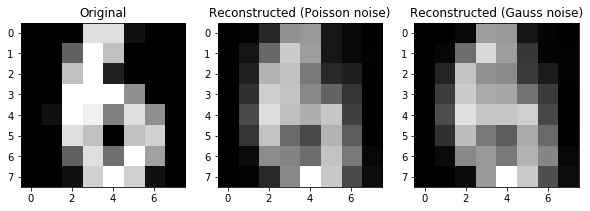

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

rand = np.random.randint(X.shape[0])
ax[0].set_title('Original')
ax[0].imshow(X[rand].reshape(8,8), cmap='gray')
ax[1].set_title('Reconstructed (Poisson noise)')
ax[1].imshow(np.dot(W_poisson[rand], H_poisson).reshape(8,8), cmap='gray')
ax[2].set_title('Reconstructed (Gauss noise)')
ax[2].imshow(np.dot(W_gauss[rand], H_gauss).reshape(8,8), cmap='gray')

As we can see, both NMF methods perform similar, the Gaussian looks a bit more fuzzy.

## 4. Recommender System

In [152]:
# column headers for the dataset
ratings_cols = ['user id','movie id','rating','timestamp']
movies_cols = ['movie id','movie title','release date',
'video release date','IMDb URL','unknown','Action',
'Adventure','Animation','Childrens','Comedy','Crime',
'Documentary','Drama','Fantasy ','Film-Noir','Horror',
'Musical','Mystery','Romance','Sci-Fi','Thriller',
'War' ,'Western']
users_cols = ['user id','age','gender','occupation ', 'zip code']

# import files
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# joint ratings dataframe
fill_value = 0
rat_df = ratings.pivot(index='user id', columns='movie id', values='rating').fillna(fill_value)
sparsity = lambda matrix : 1 - np.count_nonzero(matrix) / np.product(rat_df.shape)
print('Sparsity of ratings matrix: {:.4f}'.format(sparsity(rat_df)))

Sparsity of ratings matrix: 0.9370


In [153]:
W, H = non_negative(rat_df, num_components=25)
reconstruction = pd.DataFrame(np.dot(W, H), columns=rat_df.columns)
print('Sparsity of reconstruction matrix: {:.4f}'.format(sparsity(reconstruction)))

Sparsity of reconstruction matrix: 0.0008


In [154]:
def recommend_movies(reconstruction, user_id, movies, ratings, n=5):
    user_reconstruction = reconstruction.loc[user_id].as_matrix()
    # mask for already seen
    already_seen = ratings['movie id'][ratings['user id'] == user_id].as_matrix()
    # find best ratings
    sorted_by_rating = np.argsort(user_reconstruction)
    # filter already seen movies
    filter_seen = np.logical_not(np.isin(reconstruction.columns[sorted_by_rating], already_seen))
    # index to movie id
    best_movies = reconstruction.columns[sorted_by_rating][filter_seen]
    # return last n elements in reverse order, to get movie id in descending rating
    return best_movies[:-n-1:-1]

In [157]:
recom_ids = recommend_movies(reconstruction, 399, movies, ratings)
recom_movies = movies.loc[recom_ids]
recom_movies

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
300,301,In & Out (1997),19-Sep-1997,NaN,http://us.imdb.com/Title?In+%26+Out+(1997),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
258,259,George of the Jungle (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?George+of+the...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
294,295,Breakdown (1997),02-May-1997,NaN,http://us.imdb.com/M/title-exact?Breakdown%20%...,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
286,287,Marvin's Room (1996),18-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Marvin's%20Ro...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
333,334,U Turn (1997),01-Jan-1997,NaN,http://us.imdb.com/Title?U+Turn+(1997),0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Stability

In [174]:
recommended_ids = []
for _ in range(50):
    W, H = non_negative(rat_df, num_components=25)
    reconstruction = pd.DataFrame(np.dot(W, H), columns=rat_df.columns)
    recommended_ids.append(recommend_movies(reconstruction, 399, movies, ratings))
ids, counts = np.unique(np.array(recommended_ids), return_counts=True)

In [175]:
[print(f"Movie id {id}: {count}") for id, count in zip(ids, counts)];

Movie id 258: 50
Movie id 269: 10
Movie id 272: 2
Movie id 286: 50
Movie id 294: 40
Movie id 300: 50
Movie id 313: 11
Movie id 333: 37


As we can see, 3 of the movies including the first recommended one appear in all 50 test runs, but there are some outliers, which get recommended only once.